In [1]:
import math
import numpy as np
from typing import Union, Tuple
import torch
from torch.nn import functional as F
import scipy


def sign(x: float) -> int:
    return 1 if x >= 0 else -1


def mapmm(x: torch.Tensor) -> torch.Tensor:
    minx = torch.min(x)
    maxx = torch.max(x)
    if minx < maxx:
        x = (x - minx) / (maxx - minx)
    return x


def fspecial(filter_type: str, p2: Union[int, Tuple[int, int]], p3: Union[int, float] = None) -> np.ndarray:
    if filter_type == 'gaussian':
        m, n = [(ss - 1.) / 2. for ss in p2]
        y, x = np.ogrid[-m:m + 1, -n:n + 1]
        h = np.exp(-(x * x + y * y) / (2. * p3 * p3))
        h[h < np.finfo(h.dtype).eps * h.max()] = 0
        sumh = h.sum()
        if sumh != 0:
            h /= sumh

        return h

    elif filter_type == 'disk':
        rad = p2
        crad = math.ceil(rad - 0.5)

        x, y = np.ogrid[-rad: rad + 1, -rad: rad + 1]
        y = np.tile(y.transpose(), y.shape[1])
        x = np.tile(x, x.shape[0]).transpose()

        y = np.abs(y)
        x = np.abs(x)

        maxxy = np.maximum(x, y)
        minxy = np.minimum(x, y)

        r1 = (rad ** 2 - (maxxy + 0.5) ** 2)
        r2 = (rad ** 2 - (minxy - 0.5) ** 2)

        if (r1 > 0).all():
            warn_m1 = r1 ** 0.5
        else:
            warn_m1 = 0
        if (r2 > 0).all():
            warn_m2 = r2 ** 0.5
        else:
            warn_m2 = 0

        m1 = (rad ** 2 < (maxxy + 0.5) ** 2 + (minxy - 0.5) ** 2) * (minxy - 0.5) + (
                rad ** 2 >= (maxxy + 0.5) ** 2 + (minxy - 0.5) ** 2) * warn_m1
        m2 = (rad ** 2 > (maxxy - 0.5) ** 2 + (minxy + 0.5) ** 2) * (minxy + 0.5) + (
                rad ** 2 <= (maxxy - 0.5) ** 2 + (minxy + 0.5) ** 2) * warn_m2

        sgrid = (rad ** 2 * (0.5 * (np.arcsin(m2 / rad) - np.arcsin(m1 / rad)) +
                             0.25 * (np.sin(2 * np.arcsin(m2 / rad)) - np.sin(2 * np.arcsin(m1 / rad)))) - (
                         maxxy - 0.5) * (m2 - m1) + (m1 - minxy + 0.5)) * np.logical_or(
            np.logical_and((rad ** 2 < (maxxy + 0.5) ** 2 + (minxy + 0.5) ** 2),
                           (rad ** 2 > (maxxy - 0.5) ** 2 + (minxy - 0.5) ** 2)),
            np.logical_and(np.logical_and(minxy == 0, maxxy - 0.5 < rad), maxxy + 0.5 >= rad))

        sgrid = sgrid + ((maxxy + 0.5) ** 2 + (minxy + 0.5) ** 2 < rad ** 2)
        sgrid[crad, crad] = np.minimum(math.pi * rad ** 2, math.pi / 2)
        if (crad > 0) and (rad > crad - 0.5) and (rad ** 2 < (crad - 0.5) ** 2 + 0.25):
            m1 = np.sqrt(rad ** 2 - (crad - 0.5) ** 2)
            m1n = m1 / rad
            sg0 = 2 * (rad ** 2 * (0.5 * np.arcsin(m1n) + 0.25 * np.sin(2 * np.arcsin(m1n))) - m1 * (crad - 0.5))
            sgrid[2 * crad, crad] = sg0
            sgrid[crad, 2 * crad] = sg0
            sgrid[crad, 0] = sg0
            sgrid[0, crad] = sg0
            sgrid[2 * crad, crad] = sgrid[2 * crad, crad] - sg0
            sgrid[crad, 2 * crad] = sgrid[crad, 2 * crad] - sg0
            sgrid[crad, 2] = sgrid[crad, 2] - sg0
            sgrid[2, crad] = sgrid[2, crad + 1] - sg0

        sgrid[crad, crad] = np.minimum(sgrid[crad, crad], 1)
        h = sgrid / np.sum(sgrid)
        return h
    elif filter_type == 'motion':

        eps = 2.2204e-16
        length = max(1, p2)
        half_len = (length - 1) / 2.
        phi = (p3 % 180) / 180 * math.pi

        cosphi = math.cos(phi)
        sinphi = math.sin(phi)
        xsign = sign(cosphi)
        linewdt = 1

        sx = int(half_len * cosphi + linewdt * xsign - length * eps)
        sy = int(half_len * sinphi + linewdt - length * eps)
        x, y = np.mgrid[0:sx + (1 * xsign):xsign, 0:sy + 1]
        x = x.transpose()
        y = y.transpose()

        dist2line = (y * cosphi - x * sinphi)
        rad = (x ** 2 + y ** 2) ** 0.5

        lastpix = np.where(np.logical_and((rad >= half_len), (abs(dist2line) <= linewdt)))
        x2lastpix = half_len - np.abs((x[lastpix] + dist2line[lastpix] * sinphi) / cosphi);

        dist2line[lastpix] = np.sqrt(dist2line[lastpix] ** 2 + x2lastpix ** 2)
        dist2line = linewdt + eps - np.abs(dist2line)
        dist2line[dist2line < 0] = 0

        h = np.rot90(dist2line, 2)
        tmp_h = np.zeros((h.shape[0] * 2 - 1, h.shape[1] * 2 - 1))
        tmp_h[0:h.shape[0], 0:h.shape[1]] = h
        tmp_h[(h.shape[0]) - 1:, h.shape[1] - 1:] = dist2line
        h = tmp_h

        h /= np.sum(h) + eps * length * length

        if cosphi > 0:
            h = np.flipud(h)

        return h

    else:
        raise NotImplementedError(f"Filter type {filter_type} not implemented")


def filter2D(img: torch.Tensor, kernel: torch.Tensor) -> torch.Tensor:
    """PyTorch version of cv2.filter2D
    Args:
        img (Tensor): (b, c, h, w)
        kernel (Tensor): (b, k, k)
    """
    img = img.float()
    k1 = kernel.size(-2)
    k2 = kernel.size(-1)

    b, c, h, w = img.size()
    if k1 % 2 == 1 or k2 % 2 == 1:
        img = F.pad(img, (k2 // 2, k2 // 2, k1 // 2, k1 // 2), mode='replicate')
    else:
        raise ValueError('Wrong kernel size')

    ph, pw = img.size()[-2:]

    if kernel.size(0) == 1:
        # apply the same kernel to all batch images
        img = img.view(b * c, 1, ph, pw)
        kernel = kernel.view(1, 1, k1, k2)
        return F.conv2d(img, kernel, padding=0).view(b, c, h, w)
    else:
        img = img.view(1, b * c, ph, pw)
        kernel = kernel.view(b, 1, k1, k2).repeat(1, c, 1, 1).view(b * c, 1, k1, k2)
        return F.conv2d(img, kernel, groups=b * c).view(b, c, h, w)


def curves(xx: torch.Tensor, coef: float) -> torch.Tensor:
    if type(coef) == list:
        coef = [[0.3, 0.5, 0.7],
                [coef[0], 0.5, coef[1]]]
    else:
        coef = [[0.5], [coef]]

    x = np.array([0] + [p for p in coef[0]] + [1])
    y = np.array([0] + [p for p in coef[1]] + [1])

    cs = spline(x, y)

    yy = ppval(cs, xx)

    yy = torch.clamp(yy, 0, 1)

    return yy


def spline(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    n = x.shape[0]
    dd = 1
    dx = np.diff(x)
    divdif = np.diff(y) / dx

    if n == 3:
        y[1:3] = divdif
        y[2] = np.diff(divdif.T).T / (x[2] - x[0])
        y[1] -= y[2] * dx[0]
        dlk = y[[2, 1, 0]].shape[0]
        l = x[[0, 2]].shape[0] - 1
        dl = np.prod(dd) * l
        k = np.fix(dlk / dl + 100 * 2.2204e-16)

        pp = (x[[0, 2]], y[[2, 1, 0]], l, int(k), dd)

    elif n > 3:
        b = np.zeros(n)
        b[1:n - 1] = 3 * (dx[1:n] * divdif[0:n - 2] + dx[0:n - 2] * divdif[1:n])

        x31 = x[2] - x[0]
        xn = x[n - 1] - x[n - 3]

        b[0] = ((dx[0] + 2 * x31) * dx[1] * divdif[0] + dx[0] ** 2 * divdif[1]) / x31
        b[n - 1] = (dx[n - 2] ** 2 * divdif[n - 3] + (2 * xn + dx[n - 2]) * dx[n - 3] * divdif[n - 2]) / xn;

        dxt = dx.T
        c = np.zeros((3, 5))
        c[0, :] = [x31] + list(dxt[0:n - 2]) + [0]
        c[1, :] = [dxt[1]] + list(2 * (dxt[1:n - 1] + dxt[0:n - 2])) + [dxt[n - 3]]
        c[2, :] = [0] + list(dxt[1:n - 1]) + [xn]

        c = scipy.sparse.dia_matrix((c, [-1, 0, 1]), shape=(5, 5))
        c = scipy.sparse.csc_matrix(c)
        ic = scipy.sparse.linalg.inv(c)
        s = b * ic

        n = x.shape[0]
        d = 1
        dxd = dx

        dzzdx = (divdif - s[0:n - 1]) / dxd
        dzdxdx = (s[1:n] - divdif) / dxd

        coefs = np.vstack(((dzdxdx - dzzdx) / dxd, 2 * dzzdx - dzdxdx, s[0:n - 1], y[0:n - 1])).T

        pp = (x, coefs, x.shape[0], x.shape[0], d)
    else:
        raise ValueError('x.shape[0] must be >= 3')

    return pp


def ppval(pp: np.ndarray, xx: torch.Tensor) -> torch.Tensor:
    lx = torch.numel(xx)
    xs = xx.reshape(1, lx)
    b, c, l, k, dd = pp
    b = torch.as_tensor(b, device=xx.device)
    ranges = b.clone()
    ranges[0] = -torch.inf
    ranges[-1] = torch.inf
    index = histc(xs, ranges)

    xs = xs - b[index]

    c = torch.as_tensor(c, device=xx.device)

    if len(c.shape) == 1:
        v = c[0]
        for i in range(1, k):
            v = xs * v + c[i]
    else:
        v = c[index, 0]

        for i in range(1, k - 1):
            v = xs * v + c[index, i]
    v = v.view(xx.shape)
    return v


def histc(x: torch.Tensor, binranges: torch.Tensor) -> torch.Tensor:
    indices = torch.bucketize(x, binranges)
    return torch.remainder(indices, len(binranges)) - 1


def imscatter(x: torch.Tensor, amount: float, iterations=1) -> torch.Tensor:
    y = x
    for i in range(iterations):
        shiftmap = torch.randn((2, x.shape[1], x.shape[2]), device=x.device) * amount

        sy = shiftmap[0, :, :]
        sx = shiftmap[1, :, :]

        m_sx = torch.ceil(torch.abs(torch.max(sx))).to(torch.int32)
        m_sy = torch.ceil(torch.abs(torch.max(sy))).to(torch.int32)

        y = F.pad(y, (m_sy, m_sy), mode='replicate')
        y = F.pad(y.transpose(2, 1), (m_sx, m_sx), mode='replicate').transpose(2, 1)

        sy = F.pad(sy, (m_sy, m_sy), mode='replicate')
        sy = F.pad(sy.transpose(1, 0), (m_sx, m_sx), mode='replicate').transpose(1, 0)
        sx = F.pad(sx, (m_sy, m_sy), mode='replicate')
        sx = F.pad(sx.transpose(1, 0), (m_sx, m_sx), mode='replicate').transpose(1, 0)

        xx, yy = torch.as_tensor(np.mgrid[0:y.shape[1], 0:y.shape[2]], device=x.device)

        z = torch.zeros_like(y)
        bx = (xx - sx)
        by = (yy - sy)
        for i in range(3):
            j = bilinear_interpolate_torch(y[i, ...], by, bx)
            z[i, :, :] = j

        y = z[:, m_sy:m_sy + x.shape[1], m_sx:m_sx + x.shape[2]]
    return y


def bilinear_interpolate_torch(im: torch.Tensor, x: torch.Tensor, y: torch.Tensor, eps: float = 1e-8) -> torch.Tensor:
    dtype_long = torch.LongTensor

    x0 = torch.floor(x).type(dtype_long).to(im.device)
    x1 = x0 + 1

    y0 = torch.floor(y).type(dtype_long).to(im.device)
    y1 = y0 + 1

    x0 = torch.clamp(x0, 0, im.shape[1] - 1)
    x1 = torch.clamp(x1, 0, im.shape[1] - 1)
    y0 = torch.clamp(y0, 0, im.shape[0] - 1)
    y1 = torch.clamp(y1, 0, im.shape[0] - 1)

    Ia = im[y0, x0]
    Ib = im[y1, x0]
    Ic = im[y0, x1]
    Id = im[y1, x1]

    R1 = Ia * (x1 - x) / (x1 - x0 + eps) + Ic * (x - x0) / (x1 - x0 + eps)
    R2 = Ib * (x1 - x) / (x1 - x0 + eps) + Id * (x - x0) / (x1 - x0 + eps)
    P = R1 * (y1 - y) / (y1 - y0 + eps) + R2 * (y - y0) / (y1 - y0 + eps)
    return P

In [2]:
import torch
from torchvision.io.image import decode_jpeg, encode_jpeg
from torchvision import transforms
import numpy as np
import random
import math
from torch.nn import functional as F
import io
from PIL import Image
import ctypes
import kornia
def gaussian_blur(x: torch.Tensor, blur_sigma: int = 0.1) -> torch.Tensor:
    fs = 2 * math.ceil(2 * blur_sigma) + 1
    h = fspecial('gaussian', (fs, fs), blur_sigma)
    h = torch.from_numpy(h).float()

    if len(x.shape) == 3:
        x = x.unsqueeze(0)

    y = filter2D(x, h.unsqueeze(0)).squeeze(0)
    return y


def lens_blur(x: torch.Tensor, radius: int) -> torch.Tensor:
    h = fspecial('disk', radius)
    h = torch.from_numpy(h).float()

    if len(x.shape) == 3:
        x = x.unsqueeze(0)

    # Ensure the correct kernel size
    expected_size = (radius * 2 + 1) ** 2
    if h.numel() != expected_size:
        raise ValueError('Incorrect kernel size for lens blur')

    y = filter2D(x, h.view(1, 1, radius * 2 + 1, radius * 2 + 1)).squeeze(0)
    return y


def motion_blur(x: torch.Tensor, radius: int, angle: bool = None) -> torch.Tensor:
    if angle is None:
        angle = random.randint(0, 180)
    h = fspecial('motion', radius, angle)
    h = torch.from_numpy(h.copy()).float()

    if len(x.shape) == 3:
        x = x.unsqueeze(0)

    y = filter2D(x, h.unsqueeze(0)).squeeze(0)
    return y



def white_noise(x: torch.Tensor, var: float, clip: bool = True, rounds: bool = False) -> torch.Tensor:
    noise = torch.randn(*x.size(), dtype=x.dtype) * math.sqrt(var)

    y = x + noise

    if clip and rounds:
        y = torch.clip((y * 255.0).round(), 0, 255) / 255.
    elif clip:
        y = torch.clip(y, 0, 1)
    elif rounds:
        y = (y * 255.0).round() / 255.
    return y


def non_eccentricity_patch(x: torch.Tensor, pnum: int) -> torch.Tensor:
    y = x
    patch_size = [16, 16]
    radius = 16
    h_min = radius
    w_min = radius
    c, h, w = x.shape

    h_max = h - patch_size[0] - radius
    w_max = w - patch_size[1] - radius

    for i in range(pnum):
        w_start = round(random.random() * (w_max - w_min)) + w_min
        h_start = round(random.random() * (h_max - h_min)) + h_min
        patch = y[:, h_start:h_start + patch_size[0], w_start:w_start + patch_size[0]]

        rand_w_start = round((random.random() - 0.5) * radius + w_start)
        rand_h_start = round((random.random() - 0.5) * radius + h_start)
        y[:, rand_h_start:rand_h_start + patch_size[0], rand_w_start:rand_w_start + patch_size[0]] = patch

    return y


def pixelate(x: torch.Tensor, strength: float) -> torch.Tensor:
    z = 0.95 - strength ** 0.6
    c, h, w = x.shape

    ylo = kornia.geometry.transform.resize(x, (int(h * z), int(w * z)), 'nearest')
    y = kornia.geometry.transform.resize(ylo, (h, w), 'nearest')

    return y





In [3]:
import torch
import numpy as np
import random

# Define distortion functions
li_distort = [
    lambda x, value: white_noise(x, value, False, False),
    lambda x, value: gaussian_blur(x, value),
    lambda x, value: motion_blur(x, value*5, np.random.rand(1)*360),
    lambda x, value: pixelate(x, value*0.5),
    lambda x, value: non_eccentricity_patch(x, int(value))
]


def get_distortions_composition(max_distortions, num_levels):
    # Randomly select distortions
    selected_distortions = np.random.choice(li_distort, max_distortions, replace=False).tolist()

    # Randomly choose values for the selected distortions
    selected_values = [np.random.rand() for _ in range(max_distortions)]

    return selected_distortions, selected_values

def distort_decam_images(image: torch.Tensor, distort_functions: list = None, distort_values: list = None,
                   max_distortions: int = 4, num_levels: int = 5) -> torch.Tensor:
    """
    Distorts an image using the distortion composition obtained with the image degradation model.

    Args:
        image (Tensor): image to distort
        distort_functions (list): list of the distortion functions to apply to the image. If None, the functions are randomly chosen.
        distort_values (list): list of the values of the distortion functions to apply to the image. If None, the values are randomly chosen.
        max_distortions (int): maximum number of distortions to apply to the image
        num_levels (int): number of levels of distortion that can be applied to the image

    Returns:
        image (Tensor): distorted image
        distort_functions (list): list of the distortion functions applied to the image
        distort_values (list): list of the values of the distortion functions applied to the image
    """
    if distort_functions is None or distort_values is None:
        distort_functions, distort_values = get_distortions_composition(max_distortions, num_levels)

    for distortion, value in zip(distort_functions, distort_values):
        image = distortion(image, value)


    return image, distort_functions, distort_values

In [4]:
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval, ImageNormalize
from astropy.io import fits
from photutils.background import SExtractorBackground, Background2D
from astropy.stats import SigmaClip

def plot_image(image: torch.Tensor, title: str = "Distorted Image"):
    """
    Plot the given image.

    Args:
        image (Tensor): image to plot
        title (str): title of the plot
    """
    image = image.squeeze()

    # Display the image with Z-scaled normalization
    fig, axs = plt.subplots(figsize=(10, 8))
    norm = ImageNormalize(image, interval=ZScaleInterval())
    im = axs.imshow(image, cmap='gray', norm=norm)
    axs.set_title(title)
    fig.colorbar(im, ax=axs, label='Counts')
    plt.show()

def display_original_image(image_path, image_hdu):
    fits_file_path = image_path
    sigma_clip = SigmaClip(sigma=5.0)
    sexbkg = SExtractorBackground(sigma_clip)
    zscale_interval = ZScaleInterval()
    print(image_path)
    # Open the FITS file
    hdul = fits.open(fits_file_path)
    image_data = hdul[image_hdu].data

    bkg = Background2D(image_data, (60, 60), filter_size=(3, 3), bkg_estimator=sexbkg)
    image_data_subtracted = image_data - bkg.background

    fig, axs = plt.subplots(figsize=(10, 8))
    norm1 = ImageNormalize(image_data_subtracted, interval=zscale_interval)
    im1 = axs.imshow(image_data_subtracted, cmap='gray', norm=norm1)
    axs.set_title(f'Original Image - HDU {image_hdu}')
    fig.colorbar(im1, ax=axs, label='Counts')
    # Show the plot
    plt.show()
    

In [5]:

li_distort_names = ['white_noise', 'gaussian_blur', 'motion_blur', 'pixelate', 'non_eccentricity_patch']

# Function to get the names of distortion functions
def get_distortion_names(distort_functions, li_distort_names):
    distortion_names = []
    for distort_function in distort_functions:
        # Check if the distort function is a lambda function
        if isinstance(distort_function, type(lambda x: x)):
            # Find the index of the lambda function in li_distort
            index = li_distort.index(distort_function)
            # Map the index to the corresponding name in li_distort_names
            distortion_name = li_distort_names[index]
            distortion_names.append(distortion_name)
        else:
            # If not a lambda function, use an empty string
            distortion_names.append('')
    return distortion_names




In [15]:
import random
import torch
from torch.utils.data import Dataset
from pathlib import Path
from PIL import Image
from torchvision import transforms
import pandas as pd
import numpy as np
from astropy.io import fits
from astropy.table import Table
import os
from torchvision import transforms

class DECAMDataset(Dataset):
    """
    DECAM dataset class used for pre-training the encoders for IQA.

    Args:
        root (string): root directory of the dataset
        patch_size (int): size of the patches to extract from the images
        max_distortions (int): maximum number of distortions to apply to the images
        num_levels (int): number of levels of distortion to apply to the images
        pristine_prob (float): probability of not distorting the images

    Returns:
        dictionary with keys:
            img_A_orig (Tensor): first view of the image pair
            img_B_orig (Tensor): second view of the image pair
            img_A_name (string): name of the image of the first view of the image pair
            img_B_name (string): name of the image of the second view of the image pair
            distortion_functions (list): list of the names of the distortion functions applied to the images
            distortion_values (list): list of the values of the distortion functions applied to the images
    """

    def __init__(self,
                 root: str,
                 patch_size: int = 224,
                 max_distortions: int = 2,
                 num_levels: int = 5,
                 pristine_prob: float = 0.05):

        # Convert paths to Path objects
        ref_images_csv_path = 'ref_images.csv'
        hdu_numbers_csv_path = 'hdu_numbers.csv'
        ref_images= pd.read_csv(ref_images_csv_path)
        hdu_numbers = pd.read_csv(hdu_numbers_csv_path)
     
        ref_images = ref_images['ref_images'].tolist()
        hdu_numbers = hdu_numbers['hdu_numbers'].tolist()

        self.ref_images = [Path(path) for path in ref_images]
        self.hdu_numbers = [hdu for hdu in hdu_numbers]

        self.patch_size = patch_size
        self.max_distortions = max_distortions
        self.num_levels = num_levels
        self.pristine_prob = pristine_prob

        assert 0 <= self.max_distortions <= 7, "The parameter max_distortions must be in the range [0, 7]"
        assert 1 <= self.num_levels <= 5, "The parameter num_levels must be in the range [1, 5]"
        
        
    def __getitem__(self, index: int) -> dict:
        img_A_path = self.ref_images[index]
        hdu_number = self.hdu_numbers[index]
        hdul_A = fits.open(img_A_path)
        img_A = hdul_A[hdu_number].data
        display_original_image(img_A_path, hdu_number)
        # Select another exposure randomly
        other_exp_index = np.random.choice(np.setdiff1d(range(len(self.ref_images)), [index]))
        print(other_exp_index)
        img_B_path = self.ref_images[other_exp_index]
        hdul_B = fits.open(img_B_path)
        img_B = hdul_B[hdu_number].data
        display_original_image(img_B_path, hdu_number)
        
        # Define the RandomCrop transformation
        random_crop = transforms.RandomCrop(1024)
        
        img_A_orig = torch.tensor(img_A).unsqueeze(0)

        # Apply RandomCrop to the original image
        img_A_orig = random_crop(img_A_orig)
        
        img_B_orig = torch.tensor(img_B).unsqueeze(0)

        # Apply RandomCrop to the original image
        img_B_orig = random_crop(img_B_orig)

        # Convert the cropped image to a PyTorch tensor and unsqueeze the batch dimension

        #random cut
        
        
        distort_functions_A = []
        distort_values_A = []
        distort_functions_B = []
        distort_values_B = []

        # Distort images with (1 - self.pristine_prob) probability for image A
        if random.random() > self.pristine_prob and self.max_distortions > 0:
            img_A_orig, distort_functions_A, distort_values_A = distort_decam_images(img_A_orig,
                                                                                 max_distortions=self.max_distortions,
                                                                                 num_levels=self.num_levels)

        # Use the same distortions for image B
        img_B_orig, distort_functions_B, distort_values_B = distort_decam_images(img_B_orig, distort_functions=distort_functions_A, distort_values=distort_values_A)


        distort_functions_A_names = get_distortion_names(distort_functions_A, li_distort_names)
        distort_functions_B_names = get_distortion_names(distort_functions_B, li_distort_names)

        # Pad to make the length of distort_functions and distort_values equal for all samples
        distort_functions_A_names += [""] * (self.max_distortions - len(distort_functions_A_names))
        distort_values_A += [torch.inf] * (self.max_distortions - len(distort_values_A))

        distort_functions_B_names += [""] * (self.max_distortions - len(distort_functions_B_names))
        distort_values_B += [torch.inf] * (self.max_distortions - len(distort_values_B))

        print(distort_functions_A_names)
        plot_image(img_A_orig)
        print(distort_functions_B_names)
        plot_image(img_B_orig)

       

        return {
            "img_A_orig": img_A_orig,"img_B_orig": img_B_orig,
            "distortion_functions_A": distort_functions_A, "distortion_values_A": distort_values_A,
            "distortion_functions_B": distort_functions_B, "distortion_values_B": distort_values_B
        }

    
    def __len__(self) -> int:
        return len(self.ref_images)



/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.12/CP20170118/c4d_170118_090234_oki_Y_v1.fits.fz


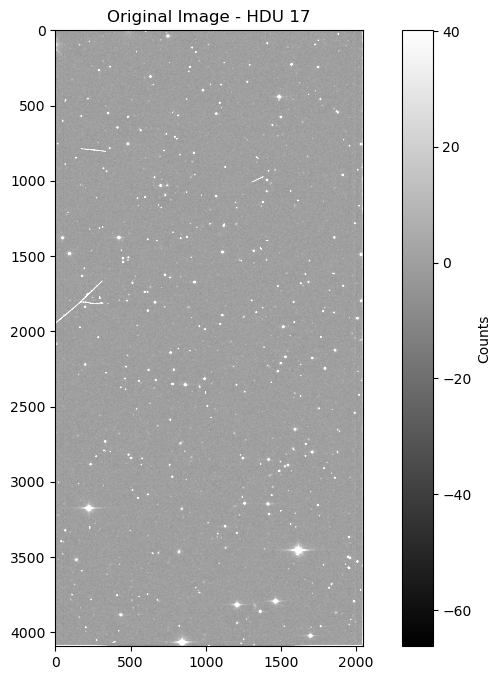

163398
/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images/decam/CP/V3.12/CP20170118/c4d_170118_090234_oki_Y_v1.fits.fz


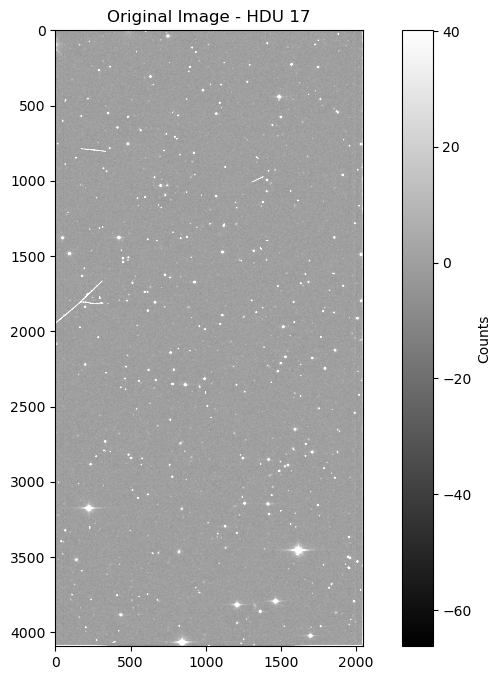

['pixelate', 'gaussian_blur']


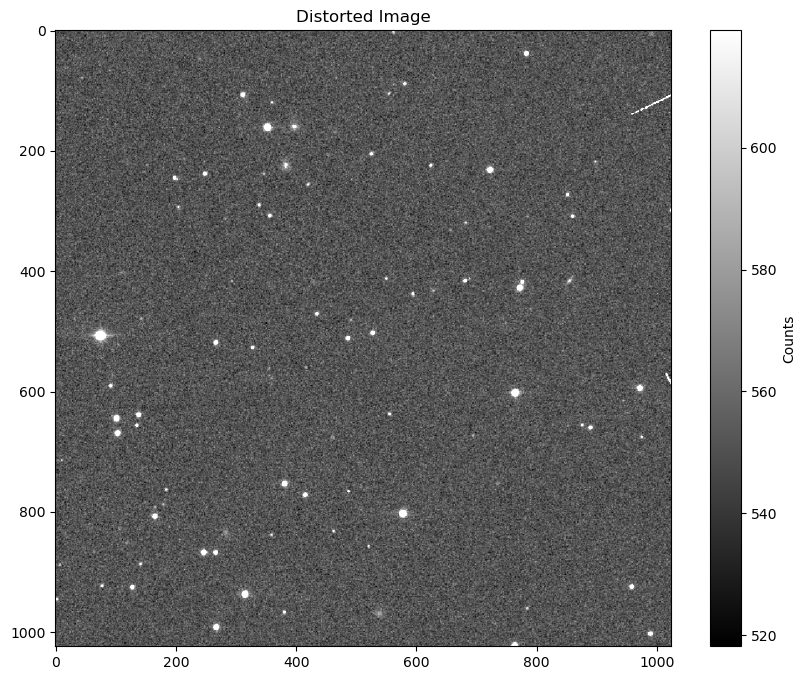

['pixelate', 'gaussian_blur']


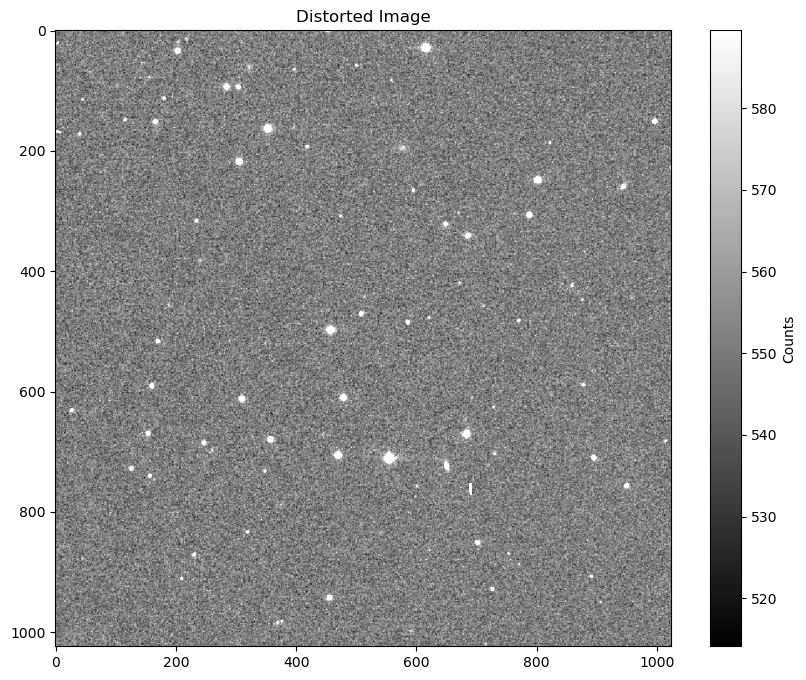

In [18]:
train_dataloader = DECAMDataset.__getitem__(train_dataset, index=334371)


In [16]:
import argparse
import torch
from torch.utils.data import DataLoader
from pathlib import Path
import random
import os
import numpy as np



    # Initialize the training dataset and dataloader
train_dataset = DECAMDataset(root="/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images",
                                    patch_size=224,
                                    max_distortions=2,
                                    num_levels=5,
                                    pristine_prob=0.05)


In [25]:
from pathlib import Path
import pandas as pd
from astropy.table import Table
import numpy as np

filenames_csv_path = "../data/decam_dr10_good_exp.csv"
exp_df = pd.read_csv(filenames_csv_path, header=None, names=["expnum"])

# Path to FITS file containing image data
file_path = "/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/survey-ccds-decam-dr10.fits.gz"
image_table = Table.read(file_path)

# List to store paths of selected images
ref_images = []
hdu_numbers = []

test = image_table
idx = np.isin(test["expnum"], exp_df["expnum"])
matched_exp = test[idx]
# Load the CSV file into a DataFrame
df = pd.read_csv("../../data/decam_dr10_ooi_oki_images_exist.csv")

# Filter the DataFrame to include only rows where oki_exist is True
df_oki_exist = df[df['oki_exist']]

# Use isin to filter matched_exp based on expnum
matched_exp_filtered = matched_exp[np.isin(matched_exp['expnum'], df_oki_exist['expnum'])]

# Replace "ooi" with "oki" in the 'image_filename' column
matched_exp_filtered['image_filename'] = matched_exp_filtered['image_filename'][0].replace("ooi", "oki")
# Print the updated 'image_filename' column
ref_images = matched_exp_filtered["image_filename"]

# Access the 'image_hdu' column
hdu_numbers = matched_exp_filtered['image_hdu']

# Convert paths to Path objects
ref_images = [Path('/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/images', path) for path in ref_images]

# Write ref_images to CSV file
ref_images_csv_path = "ref_images.csv"
pd.DataFrame({"ref_images": ref_images}).to_csv(ref_images_csv_path, index=False)

# Write hdu_numbers to CSV file
hdu_numbers_csv_path = "hdu_numbers.csv"
pd.DataFrame({"hdu_numbers": hdu_numbers}).to_csv(hdu_numbers_csv_path, index=False)


                       image_filename                       
------------------------------------------------------------
decam/CP/V3.12/CP20170118/c4d_170118_090234_oki_Y_v1.fits.fz
decam/CP/V3.12/CP20170118/c4d_170118_090234_oki_Y_v1.fits.fz
decam/CP/V3.12/CP20170118/c4d_170118_090234_oki_Y_v1.fits.fz
decam/CP/V3.12/CP20170118/c4d_170118_090234_oki_Y_v1.fits.fz
decam/CP/V3.12/CP20170118/c4d_170118_090234_oki_Y_v1.fits.fz
decam/CP/V3.12/CP20170118/c4d_170118_090234_oki_Y_v1.fits.fz
decam/CP/V3.12/CP20170118/c4d_170118_090234_oki_Y_v1.fits.fz
decam/CP/V3.12/CP20170118/c4d_170118_090234_oki_Y_v1.fits.fz
decam/CP/V3.12/CP20170118/c4d_170118_090234_oki_Y_v1.fits.fz
decam/CP/V3.12/CP20170118/c4d_170118_090234_oki_Y_v1.fits.fz
                                                         ...
decam/CP/V3.12/CP20170118/c4d_170118_090234_oki_Y_v1.fits.fz
decam/CP/V3.12/CP20170118/c4d_170118_090234_oki_Y_v1.fits.fz
decam/CP/V3.12/CP20170118/c4d_170118_090234_oki_Y_v1.fits.fz
decam/CP/V3.12/CP2017011

In [4]:
import pandas as pd
hdu_numbers_csv_path = 'hdu_numbers.csv'
hdu_numbers = pd.read_csv(hdu_numbers_csv_path)
print(len(hdu_numbers))
ref_images_csv_path = 'ref_images.csv'
ref_images= pd.read_csv(ref_images_csv_path)
print(len(ref_images))

754816
754816
